# Load and test pre-trained models



In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import SymLogNorm
from tensorflow.keras.models import load_model

import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess
from src.model import transform_batch, plot_history

models_path = "../../models/"

In [20]:
datestring = "2024_05_29T114725"

model_path = os.path.join(models_path,datestring) + ".keras"
model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,497 (13.66 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

 Optimizer params: 2,320 (9.07 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: title={'center': 'Last 6 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

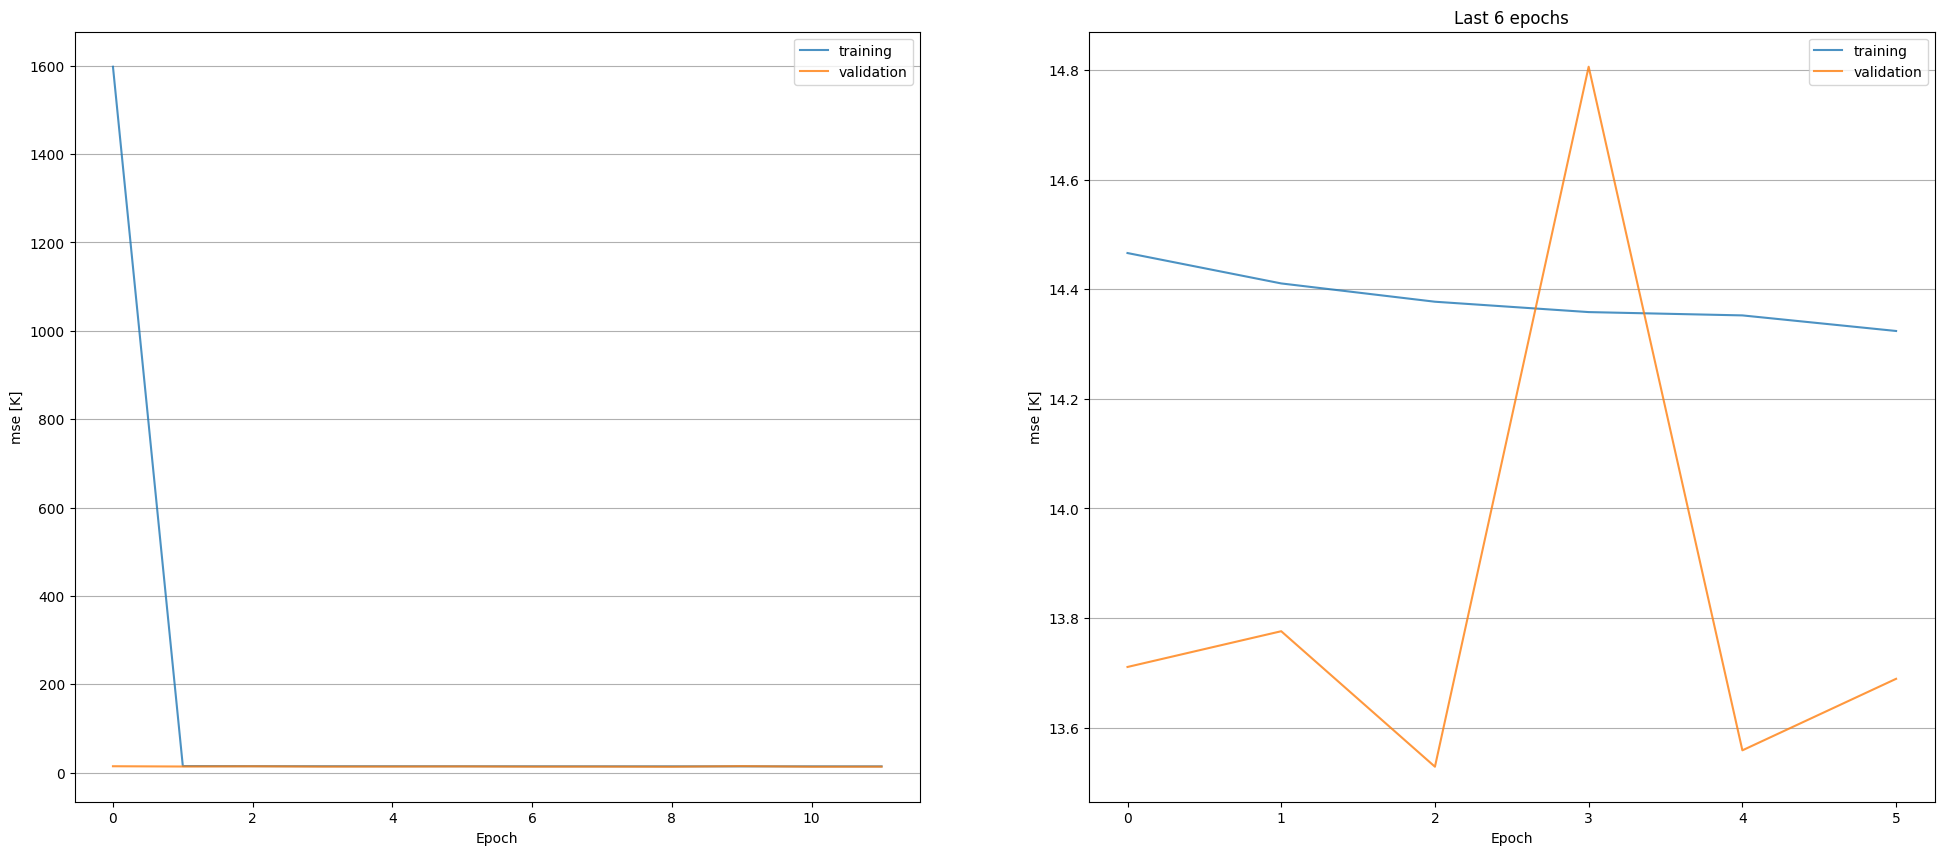

In [21]:
# Load and plot training history
history_path = os.path.join(models_path, datestring) + "_history"
with open(history_path, "rb") as file:
    history = pickle.load(file)
plot_history(history)


In [22]:

folder_path = "../../data/raw/Daily_Windsat/"
# Load windsat dataset, and trasnform it to feed it to the model
ds = windsat_datacube(folder_path)
ascds = model_preprocess(ds)

ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)

transfomed_df = transform_batch(ascds_df)

# Remove the time of observation, FOR SOME MODELS
# transfomed_df = transfomed_df[[col for col in transfomed_df.columns if col not in ["time_18Ghz","time_37Ghz"]]]

# Predict on the model and append the predicted srutep
ascds_df["surtep_MODEL"] = model.predict(transfomed_df[[col for col in transfomed_df.columns if col != "surtep_ERA5"]])
ascds_df["error"] = ascds_df["surtep_ERA5"] - ascds_df["surtep_MODEL"]
ascds_df

17874/17874 ━━━━━━━━━━━━━━━━━━━━ 11s 637us/step


,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,surtep_MODEL,error
212694,1,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,5.365944e+08,5.365944e+08,286.024841,-10.130402
232835,1,276.849609,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,5.365944e+08,5.365945e+08,288.096252,-11.246643
232838,1,277.820099,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,5.365944e+08,5.365945e+08,287.589905,-9.769806
232839,1,278.050476,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,5.365944e+08,5.365944e+08,287.755188,-9.704712
232840,1,277.954346,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,5.365944e+08,5.365944e+08,287.457275,-9.502930
...,...,...,...,...,...,...,...,...,...,...,...,...
21661288,21,276.515686,70.625,22.125,202.862488,140.917496,215.862503,169.722504,5.383268e+08,5.383268e+08,264.406006,12.109680
21661289,21,275.758698,70.625,22.375,208.297485,151.820007,217.259995,175.607498,5.383268e+08,5.383268e+08,260.084564,15.674133
21705886,21,275.418823,78.375,11.625,196.614990,127.227493,208.505005,153.690002,5.383269e+08,5.383269e+08,264.406860,11.011963
21705887,21,275.177582,78.375,11.875,196.882492,127.707497,208.345001,153.547501,5.383269e+08,5.383269e+08,264.093201,11.084381


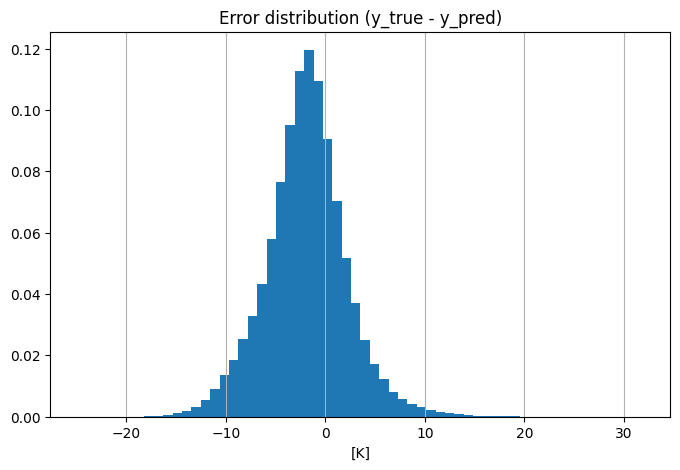

In [23]:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = ascds_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

### NOTE:
Since the testing dataset is Jan 1st to Jan 21st, the mse should be biased towards negative values (aka, day_number is not doing anything ... )

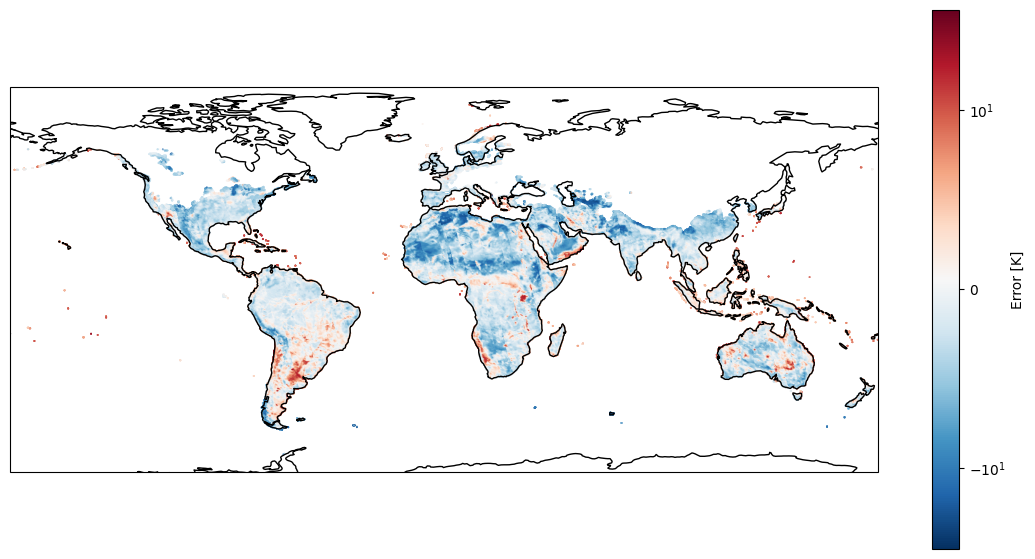

In [24]:
# Testing by predicting the whole dataset:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = SymLogNorm(linthresh=11)

scatter = ax.scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()


### Some areas with poor performance

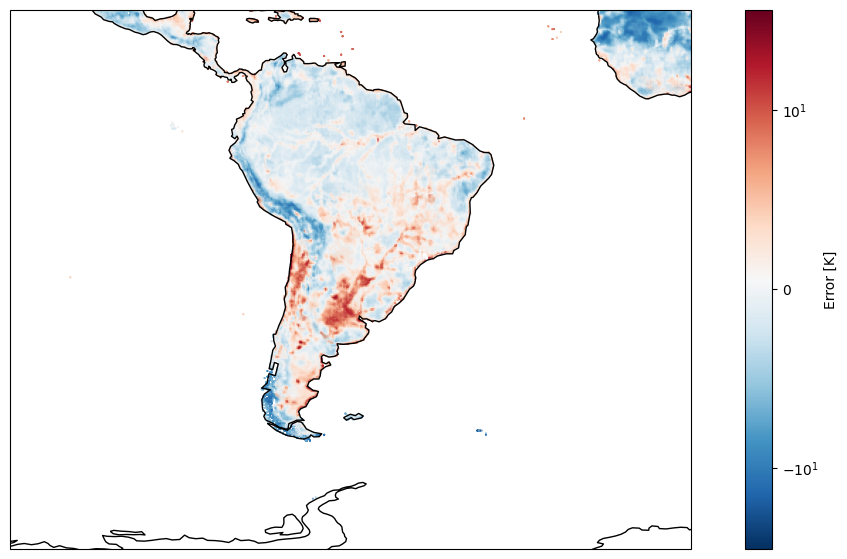

In [25]:
south_america = [(-75,20),(-120,0)]

ax.set_ylim(south_america[0])
ax.set_xlim(south_america[1])

fig

### This consistent over-estimation of the temperature in the Andes could be due to the model not beeing altitude-aware

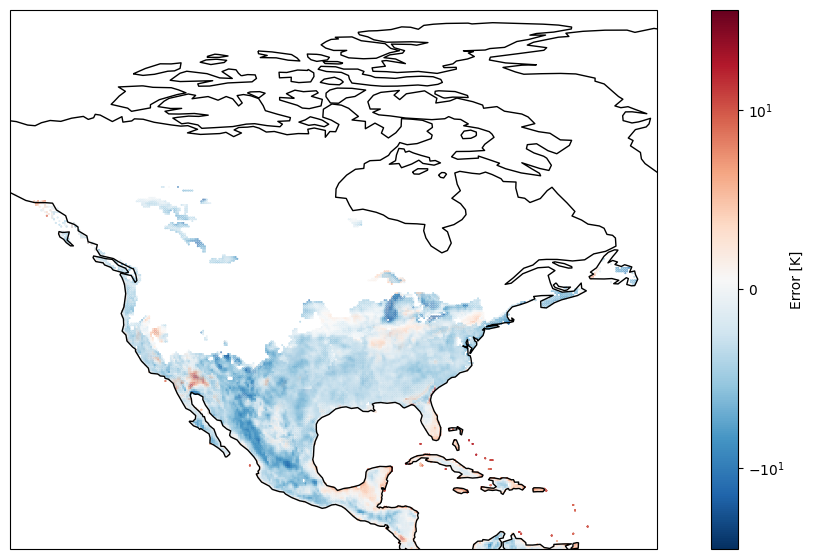

In [26]:
# Selec some problematic areas:
north_america = [(10,85),(-140,-50)]

ax.set_ylim(north_america[0])
ax.set_xlim(north_america[1])

fig

### Big lakes (Michigan) mess up the model too, we should remove Water bodies from training, maybe  also in validation.

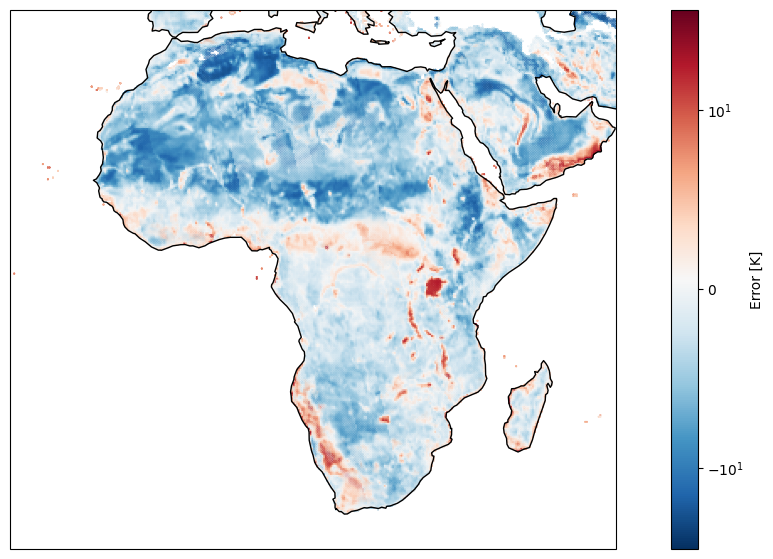

In [27]:
central_africa = [(-40,40),(-30,60)]

ax.set_ylim(central_africa[0])
ax.set_xlim(central_africa[1])

fig

### Some very high error (predicted temp is hoter than measured) near the small lakes in central africa.

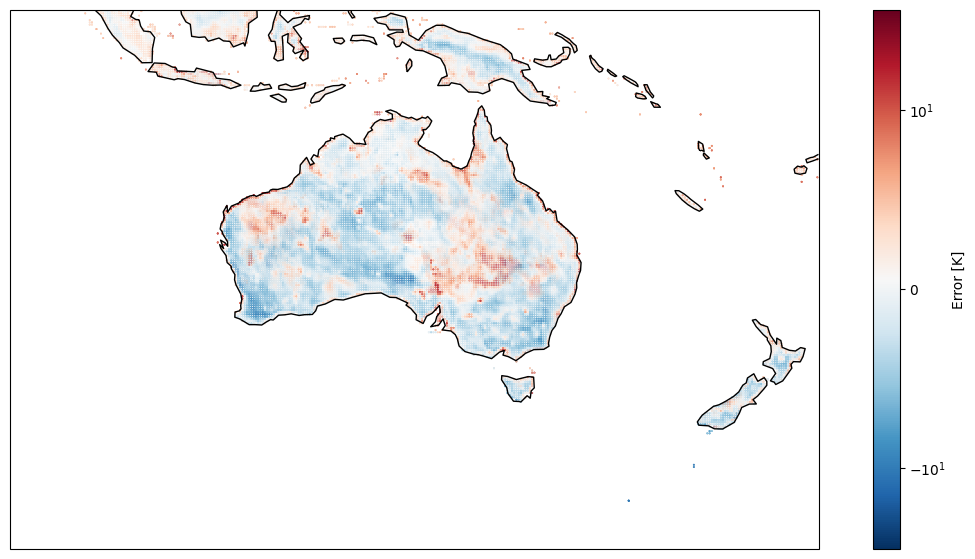

In [28]:
australia = [(-60,0),(90,180)]

ax.set_ylim(australia[0])
ax.set_xlim(australia[1])

fig

#### Lets plot the surtep from ERA5 and the model side by side to see if the features are a product of the real data or not

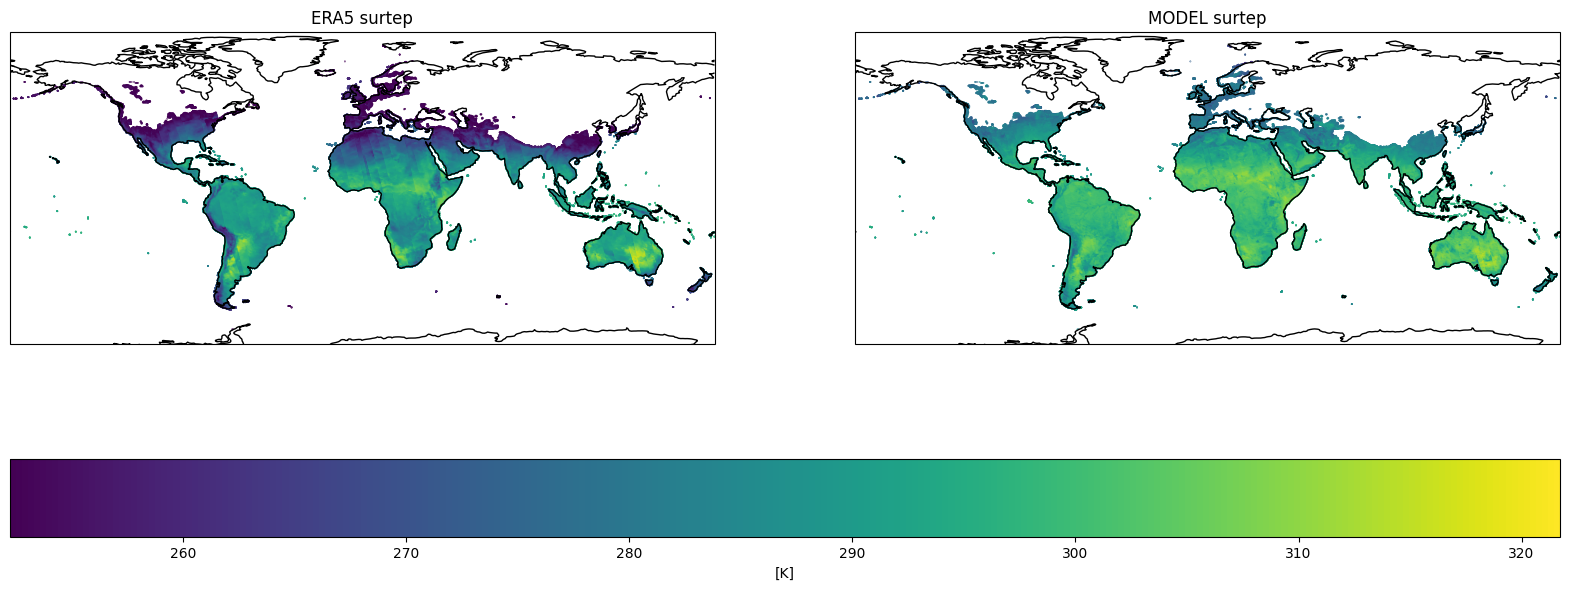

In [29]:
# Testing by predicting the whole dataset:
fig, ax = plt.subplots(1,2,figsize = (20,10), subplot_kw={"projection":ccrs.PlateCarree()} )

ax[0].coastlines("110m")
ax[1].coastlines("110m")

scatter = ax[0].scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["surtep_ERA5"],
    cmap = "viridis",
)
ax[0].set_title("ERA5 surtep")

scatter = ax[1].scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["surtep_MODEL"],
    cmap = "viridis",
)
ax[1].set_title("MODEL surtep")


fig.colorbar(scatter, ax=ax, orientation='horizontal', label='[K]')
plt.show()

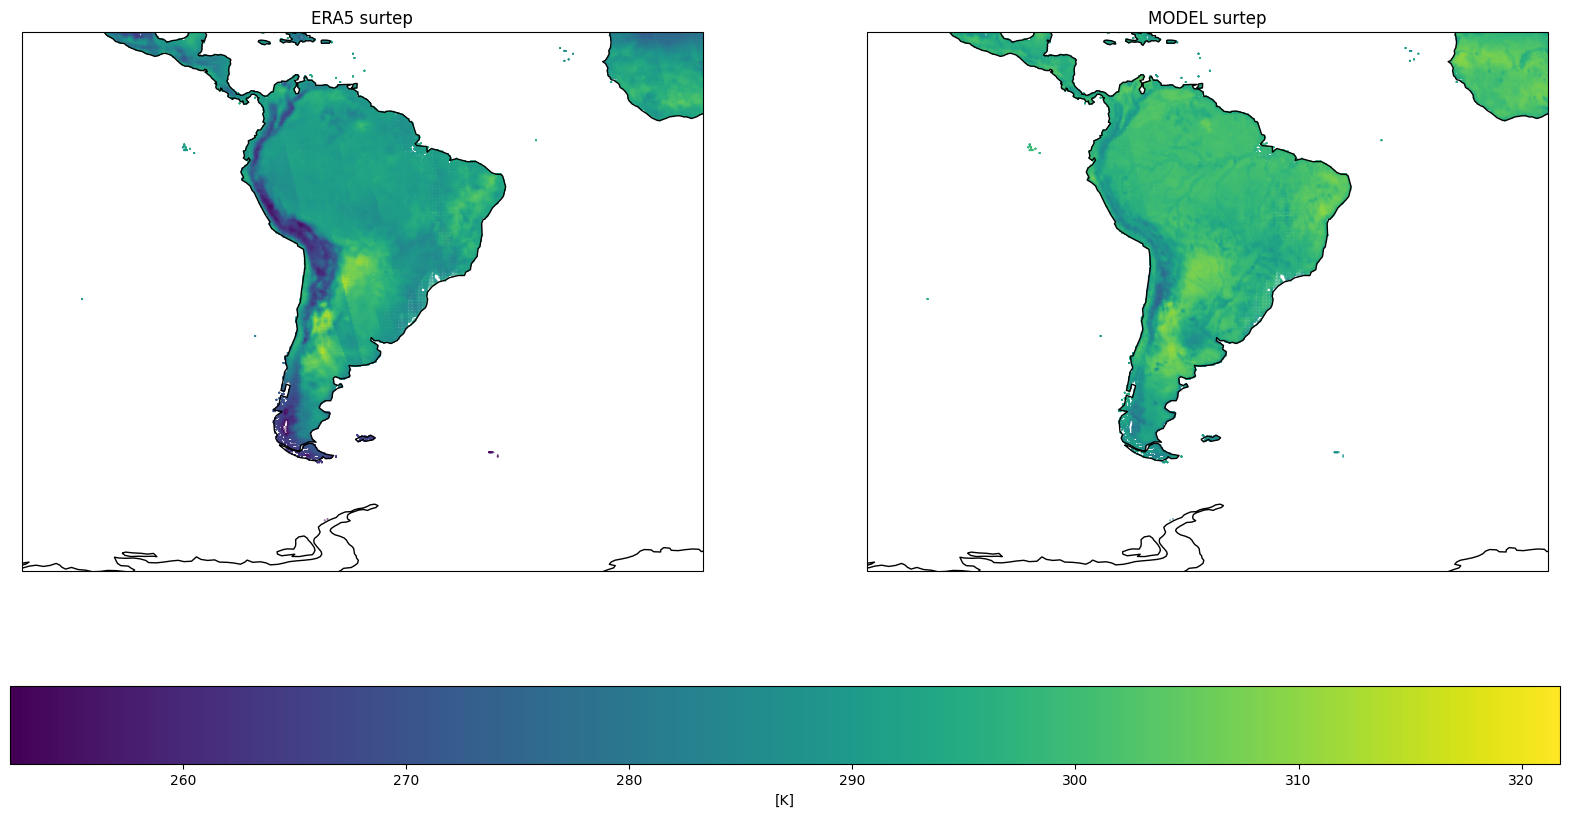

In [30]:
south_america = [(-75,20),(-120,0)]

ax[0].set_ylim(south_america[0])
ax[0].set_xlim(south_america[1])

ax[1].set_ylim(south_america[0])
ax[1].set_xlim(south_america[1])

fig